# Convolutional Neural Network for Custom ImBalanced Image Dataset

In [1]:
#!pip install torch
#!pip install torch torchvision torchaudio
#!pip install numpy
#!pip install matplotlib
#!pip install seaborn
#!pip install scikit-learn
#!pip install scikit-optimize
#!pip install pillow
#!pip install opencv-python
#!pip install ray[tune]
#!pip install pandas
#!pip install torchsummary

In [ ]:
import os
import copy
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torchsummary
import seaborn as sns
import sklearn
import random
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import cv2
import torch.nn.functional as F
import torch.optim.lr_scheduler as lr_scheduler
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from torch.utils.data import Subset, dataloader
from torchvision import models
from PIL import Image
from collections import Counter
from torch.utils.data import dataloader
from torch.utils.data import WeightedRandomSampler, Subset
from torchvision import datasets
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, recall_score, f1_score
from torch.utils.data import ConcatDataset, WeightedRandomSampler
import os
import torch
import copy
import numpy as np
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import DataLoader, Subset
from collections import Counter # Import Counter
import torch
import copy
import numpy as np
from sklearn.model_selection import KFold
from torch.utils.data import Subset, dataloader
from torchvision import models


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Data Loading and Pre-Processing

In [4]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
train_dir = '/content/drive/MyDrive/project-Pneuomonia/archive/chest_xray/train/'
val_dir = '/content/drive/MyDrive/project-Pneuomonia/archive/chest_xray/val/'
test_dir = '/content/drive/MyDrive/project-Pneuomonia/archive/chest_xray/test/'

In [ ]:
train_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize ((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        ])

val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize ((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(), # Added ToTensor()
        transforms.Normalize ((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

train_normal_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.Grayscale(num_output_channels=3),
            transforms.RandomRotation(degrees=10),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            #transforms.RandomResizedCrop(224),
            transforms.RandomResizedCrop(224, scale=(0.8, 1.0)), # Adjust scale range
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), shear=10), # Add translation and shear
            transforms.ElasticTransform(alpha=50.0, sigma=5.0), # Add elastic transform 
            transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.1), # Add Gaussian noise with a low probability
            transforms.ToTensor(),
            transforms.Normalize ((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
            ])

In [7]:
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
val_dataset = datasets.ImageFolder(val_dir, transform=train_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform=train_transforms)

## Data Visualisation

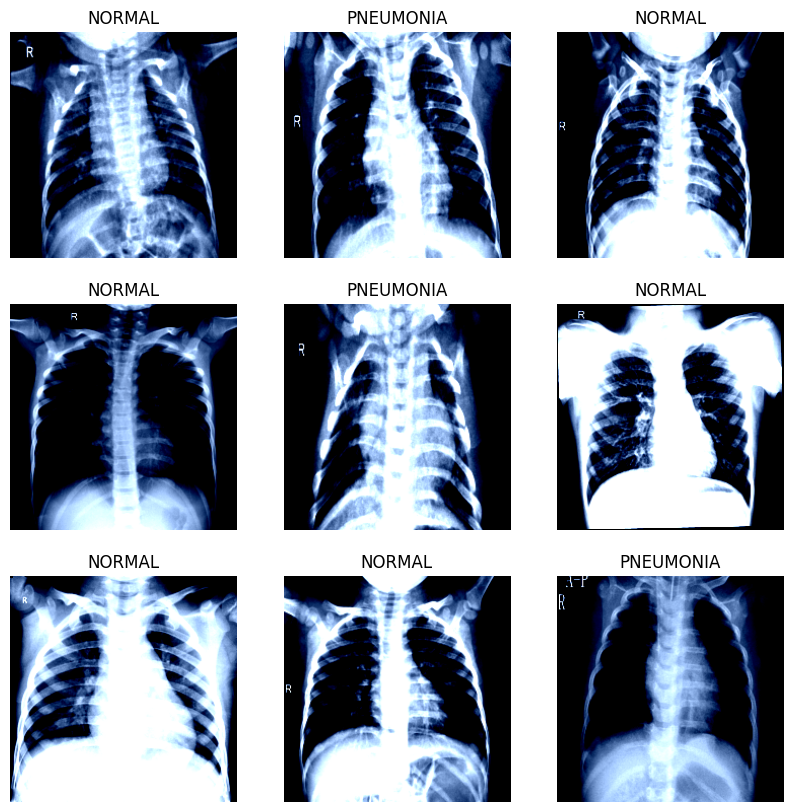

In [8]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
axes = axes.flatten()
for i in range(9):
    ax = axes[i]

    #idx = random.randint(0, len(train_dataset)-1)
    idx = random.randint(0, len(train_dataset)-1)
    img, label = train_dataset[idx]
    #img, label = train_dataset[idx]
    img = img.clip(0,1)
    ax.imshow(img.permute(1, 2, 0))
    ax.set_title(train_dataset.classes[label])
    #ax.set_title(train_dataset.classes[label])
    ax.axis('off')
plt.show()


## Weight Sampling & Overloading: imbalanced dataset

In [9]:
# Determine the class distribution of the existing datasets.
def count_class_distribution(dataset):
    targets = dataset.targets
    class_counts = Counter(targets)
    return class_counts

train_class_dist = count_class_distribution(train_dataset)
val_class_dist = count_class_distribution(val_dataset)
test_class_dist = count_class_distribution(test_dataset)

print("Training dataset class distribution:", train_class_dist)
print("Validation dataset class distribution:", val_class_dist)
print("Test dataset class distribution:", test_class_dist)


Training dataset class distribution: Counter({1: 3875, 0: 1297})
Validation dataset class distribution: Counter({0: 8, 1: 8})
Test dataset class distribution: Counter({1: 390, 0: 234})


In [ ]:
# Combine the existing datasets and then split them into new train, validation, and test sets using stratification.

# Get all image paths and labels from the original datasets
all_image_paths = []
all_labels = []

for dataset in [train_dataset, val_dataset, test_dataset]:
    for path, label in dataset.samples:
        all_image_paths.append(path)
        all_labels.append(label)

# Define the proportions for the new splits
train_size = 0.7
val_size = 0.15
test_size = 0.15

# Split into train and remaining (validation + test)
train_paths, remaining_paths, train_labels, remaining_labels = train_test_split(
    all_image_paths,
    all_labels,
    train_size=train_size,
    stratify=all_labels,
    random_state=42
)

# Split remaining into validation and test
val_paths, test_paths, val_labels, test_labels = train_test_split(
    remaining_paths,
    remaining_labels,
    test_size=test_size/(test_size + val_size), 
    stratify=remaining_labels,
    random_state=42
)

# Create dummy dataset classes to work with ImageFolder structure
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        # Determine classes based on unique labels
        self.classes = sorted(list(set(labels)))
        # Create a samples list compatible with ImageFolder's expectation (path, class_index)
        self.samples = [(path, label) for path, label in zip(image_paths, labels)]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

# Create new datasets
new_train_dataset = CustomDataset(train_paths, train_labels, transform=train_transforms)
new_val_dataset = CustomDataset(val_paths, val_labels, transform=val_transform)
new_test_dataset = CustomDataset(test_paths, test_labels, transform=test_transform)

print("New train dataset size:", len(new_train_dataset))
print("New validation dataset size:", len(new_val_dataset))
print("New test dataset size:", len(new_test_dataset))

# Optional: Verify the distribution in the new splits
print("New training dataset class distribution:", Counter(new_train_dataset.labels))
print("New validation dataset class distribution:", Counter(new_val_dataset.labels))
print("New test dataset class distribution:", Counter(new_test_dataset.labels))

# Update dataset variables
train_dataset = new_train_dataset
val_dataset = new_val_dataset
test_dataset = new_test_dataset


New train dataset size: 4068
New validation dataset size: 872
New test dataset size: 872
New training dataset class distribution: Counter({1: 2991, 0: 1077})
New validation dataset class distribution: Counter({1: 641, 0: 231})
New test dataset class distribution: Counter({1: 641, 0: 231})


In [11]:

# Calculate the actual ratio for oversampling
ratio = Counter(new_train_dataset.labels)[1] / Counter(new_train_dataset.labels)[0]

# Determine the number of samples to add to the minority class
num_minority_samples_to_add = int(Counter(new_train_dataset.labels)[0] * (ratio - 1))

# Get the minority class indices
minority_indices = [i for i, label in enumerate(new_train_dataset.labels) if label == 0]

# Randomly sample with replacement from the minority class indices
oversampled_minority_indices = random.choices(minority_indices, k=num_minority_samples_to_add)

# Combine the original dataset indices with the oversampled minority indices
all_indices = list(range(len(new_train_dataset))) + oversampled_minority_indices

# Create a new dataset with the combined indices
oversampled_train_dataset = Subset(new_train_dataset, all_indices)

print("Original train dataset size:", len(new_train_dataset))
print("Oversampled train dataset size:", len(oversampled_train_dataset))
print("Oversampled train dataset class distribution:", Counter(oversampled_train_dataset.dataset.labels[i] for i in oversampled_train_dataset.indices))



Original train dataset size: 4068
Oversampled train dataset size: 5981
Oversampled train dataset class distribution: Counter({1: 2991, 0: 2990})


In [12]:
#Apply train_normal_transform  to oversampled_train_dataset
oversampled_train_dataset.dataset.transform = train_normal_transform

# Get the labels for the oversampled dataset
oversampled_labels = [oversampled_train_dataset.dataset.labels[i] for i in oversampled_train_dataset.indices]

# Calculate weights for weighted random sampling
class_counts = Counter(oversampled_labels)
num_samples = len(oversampled_labels)
class_weights = {cls: num_samples / count for cls, count in class_counts.items()}
weights = [class_weights[label] for label in oversampled_labels]

# Create a WeightedRandomSampler
sampler = WeightedRandomSampler(weights, num_samples, replacement=True)


In [13]:

image_size = (3, 224, 224)
num_classes = 1 # Binary classification output

## CNN Architecture Design

In [ ]:
class CNNModel(nn.Module):
    def __init__(self, image_shape, **kwargs):
        super(CNNModel, self).__init__()

        # Convolutional Block 1
        self.conv1 = nn.Conv2d(image_shape[0], 32, kernel_size=(3, 3), padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3, 3), padding=1)
        self.bn1_2 = nn.BatchNorm2d(64) 
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)


        # Convolutional Block 2
        self.conv3 = nn.Conv2d(64, 128, kernel_size=(3, 3), padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=(3, 3), padding=1)
        self.bn2_2 = nn.BatchNorm2d(256) 
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)


        # Convolutional Block 3
        self.conv5 = nn.Conv2d(256, 512, kernel_size=(3, 3), padding=1)
        self.bn3 = nn.BatchNorm2d(512) 
        self.conv6 = nn.Conv2d(512, 512, kernel_size=(3, 3), padding=1)
        self.bn3_2 = nn.BatchNorm2d(512) 
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Flatten and FC with Global Average Pooling and a single Linear layer
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc_final = nn.Linear(512, num_classes)


    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.bn1(x)
        x = F.relu(self.conv2(x))
        x = self.bn1_2(x) 
        x = self.pool1(x)
        x = F.relu(self.conv3(x))
        x = self.bn2(x)
        x = F.relu(self.conv4(x))
        x = self.bn2_2(x) 
        x = self.pool2(x)
        x = F.relu(self.conv5(x))
        x = self.bn3(x) 
        x = F.relu(self.conv6(x))
        x = self.bn3_2(x) 
        x = self.adaptive_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc_final(x)
        return x

## Stratified_KFold Model training

In [ ]:
# 2. Training Function with Stratified K-Fold
# -------------------------------------------------------------------


def train_model_stratified_kfold(train_dataset, val_dataset, image_shape, k_folds=3, monitor_metric="recall"):
    """
    Performs Stratified K-Fold training
    on a binary classification dataset with .labels attribute.
    Reports val_loss and val_accuracy each epoch.
    """

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Extract all labels for stratification
    indices = np.arange(len(train_dataset))
    labels = np.array([train_dataset.dataset.labels[i] for i in train_dataset.indices])

    skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

    best_metric_value = float('-inf') if monitor_metric == "recall" or monitor_metric == "accuracy" or monitor_metric == "f1" else float('inf')
    best_model_10 = None

    # Define Focal Loss (adjust gamma and alpha as needed)
    class FocalLoss(nn.Module):
        def __init__(self, alpha=0.25, gamma=2):
            super(FocalLoss, self).__init__()
            self.alpha = alpha
            self.gamma = gamma

        def forward(self, inputs, targets):
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
            pt = torch.exp(-BCE_loss)
            F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss
            return F_loss.mean()

    # Loop over folds
    for fold, (train_indices, val_indices) in enumerate(skf.split(indices, labels)):
        val_loss_history = []
        val_accuracy_history = []
        train_loss_history = []
        train_accuracy_history = []

        print(f"Fold {fold + 1}/{k_folds}")
        train_subset = Subset(train_dataset.dataset, [train_dataset.indices[i] for i in train_indices])
        val_subset = Subset(train_dataset.dataset, [train_dataset.indices[i] for i in val_indices])

        #Balanced loss: compute class weights on train fold
        fold_train_labels = [train_subset.dataset.labels[i] for i in train_subset.indices]
        class_counts = Counter(fold_train_labels)
        num_samples = len(fold_train_labels)
        class_weights = {cls: num_samples / count for cls, count in class_counts.items()}
        weights = [class_weights[label] for label in fold_train_labels]
        sampler = WeightedRandomSampler(weights, num_samples, replacement=True)

        train_loader = DataLoader(train_subset, batch_size=32, sampler=sampler,num_workers=2)
        val_loader = DataLoader(val_subset, batch_size=32,num_workers=2)

        model = CNNModel((3, image_shape[0], image_shape[1])).to(device)
        criterion = FocalLoss().to(device)
        optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5) # Added weight decay
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3) # Changed to ReduceLROnPlateau

        patience_counter = 0 # Initialize patience counter

        for epoch in range(50):
            model.train()
            train_total_loss = 0.0
            train_total = 0
            train_correct = 0
            for images, labels in train_loader:
                optimizer.zero_grad()
                images, labels = images.to(device), labels.to(device)
                labels = labels.float().unsqueeze(1)
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                train_total_loss += loss.item()
                predicted = (torch.sigmoid(outputs) > 0.5).long()
                train_total += labels.size(0)
                train_correct += (predicted.squeeze() == labels.squeeze().long()).sum().item()
            train_loss_history.append(train_total_loss / len(train_loader))
            train_accuracy_history.append(train_correct / train_total)


            model.eval()
            val_true_labels = []
            val_final_preds = []
            val_total_loss = 0.0
            val_total = 0
            val_correct = 0
            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)
                    labels = labels.float().unsqueeze(1)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    val_total_loss += loss.item()
                    predicted = (torch.sigmoid(outputs) > 0.5).long()
                    val_true_labels.extend(labels.squeeze().tolist())
                    val_final_preds.extend(predicted.squeeze().tolist())
                    val_total += labels.size(0)
                    val_correct += (predicted.squeeze() == labels.squeeze().long()).sum().item()


            val_loss = val_total_loss / len(val_loader) if len(val_loader) > 0 else 0.0 # Avoid division by zero
            val_accuracy = val_correct / val_total if val_total > 0 else 0.0 # Avoid division by zero
            val_loss_history.append(val_loss)
            val_accuracy_history.append(val_accuracy)
            scheduler.step(val_loss) # Step the scheduler based on validation loss

            # Calculate precision and recall for validation set
            val_precision = precision_score(val_true_labels, val_final_preds) if len(val_true_labels) > 0 else 0.0 # Avoid division by zero
            val_recall = recall_score(val_true_labels, val_final_preds) if len(val_true_labels) > 0 else 0.0 # Avoid division by zero
            val_f1 = f1_score(val_true_labels, val_final_preds) if len(val_true_labels) > 0 else 0.0 # Avoid division by zero


            current_metric_value = 0
            if monitor_metric == "recall":
                current_metric_value = val_recall
            elif monitor_metric == "accuracy":
                current_metric_value = val_accuracy
            elif monitor_metric == "f1":
                current_metric_value = val_f1
            elif monitor_metric == "loss":
                current_metric_value = val_loss

            if (monitor_metric == "loss" and current_metric_value < best_metric_value) or \
               (monitor_metric != "loss" and current_metric_value > best_metric_value):
                best_metric_value = current_metric_value
                best_model_08 = copy.deepcopy(model)
                torch.save(best_model_08.state_dict(), '/content/drive/MyDrive/checkpoints/best_model_10.pth')
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= 3:
                    print(f'Early stopping at epoch {epoch+1}')
                    break


        #print metrics
        print(f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}, Val F1: {val_f1:.4f}')
        print(f'Train Loss: {train_total_loss / len(train_loader):.4f}, Train Accuracy: {train_correct / train_total:.4f}')



    return best_model_10, best_metric_value, val_loss, val_accuracy, val_precision, val_recall, val_f1

In [28]:

history = train_model_stratified_kfold(oversampled_train_dataset, val_dataset, image_size)

Fold 1/3
Early stopping at epoch 8
Val Loss: 0.0146, Val Accuracy: 0.9228, Val Precision: 0.9470, Val Recall: 0.8957, Val F1: 0.9206
Train Loss: 0.0139, Train Accuracy: 0.9215
Fold 2/3
Early stopping at epoch 3
Val Loss: 0.0270, Val Accuracy: 0.8245, Val Precision: 0.7811, Val Recall: 0.9017, Val F1: 0.8371
Train Loss: 0.0255, Train Accuracy: 0.8465
Fold 3/3
Early stopping at epoch 3
Val Loss: 0.0246, Val Accuracy: 0.8369, Val Precision: 0.8182, Val Recall: 0.8666, Val F1: 0.8417
Train Loss: 0.0244, Train Accuracy: 0.8455


In [29]:
#plot train loss, valo loss, train accuracy, val accuracy
import matplotlib.pyplot as plt

# The history variable contains: (best_model, best_metric_value, val_loss, val_accuracy, val_precision, val_recall, val_f1)
# Access the values correctly:
best_metric_value = history[1]
final_val_loss = history[2]
final_val_accuracy = history[3]
final_val_precision = history[4]
final_val_recall = history[5]
final_val_f1 = history[6]


print(f'Best Monitored Metric Value: {best_metric_value:.4f}')
print(f'Final Validation Loss (from best fold): {final_val_loss:.4f}')
print(f'Final Validation Accuracy (from best fold): {final_val_accuracy:.4f}')
print(f'Final Validation Precision (from best fold): {final_val_precision:.4f}')
print(f'Final Validation Recall (from best fold): {final_val_recall:.4f}')
print(f'Final Validation F1 Score (from best fold): {final_val_f1:.4f}')


Best Monitored Metric Value: 0.9107
Final Validation Loss (from best fold): 0.0246
Final Validation Accuracy (from best fold): 0.8369
Final Validation Precision (from best fold): 0.8182
Final Validation Recall (from best fold): 0.8666
Final Validation F1 Score (from best fold): 0.8417


In [30]:
# evaluate best model of test set
best_model = CNNModel(image_size).to(device)
best_model.load_state_dict(torch.load('/content/drive/MyDrive/checkpoints/best_model_10.pth'))
best_model.eval()

CNNModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1_2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2_2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, tra

## Evaluation on Test dataset

In [31]:
test_loader = DataLoader(test_dataset, batch_size=32)

In [32]:
# Recall, Precision , Fi-score
from sklearn.metrics import precision_score, recall_score, f1_score
true_labels = []
final_preds = []
test_total_loss = 0.0
test_total = 0
test_correct = 0
best_model.eval()
with torch.no_grad():
  for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    labels = labels.float().unsqueeze(1)
    outputs = best_model(images)
    predicted = (torch.sigmoid(outputs) > 0.5).long()
    true_labels.extend(labels.squeeze().tolist())
    final_preds.extend(predicted.squeeze().tolist())
    test_total += labels.size(0)
    test_correct += (predicted.squeeze() == labels.squeeze().long()).sum().item()
    print(f'Test Loss: {test_total_loss / len(test_loader):.4f}, Test Accuracy: {test_correct / test_total:.4f}')



Test Loss: 0.0000, Test Accuracy: 0.9062
Test Loss: 0.0000, Test Accuracy: 0.9531
Test Loss: 0.0000, Test Accuracy: 0.9688
Test Loss: 0.0000, Test Accuracy: 0.9531
Test Loss: 0.0000, Test Accuracy: 0.9563
Test Loss: 0.0000, Test Accuracy: 0.9531
Test Loss: 0.0000, Test Accuracy: 0.9464
Test Loss: 0.0000, Test Accuracy: 0.9297
Test Loss: 0.0000, Test Accuracy: 0.9167
Test Loss: 0.0000, Test Accuracy: 0.9219
Test Loss: 0.0000, Test Accuracy: 0.9205
Test Loss: 0.0000, Test Accuracy: 0.9219
Test Loss: 0.0000, Test Accuracy: 0.9207
Test Loss: 0.0000, Test Accuracy: 0.9152
Test Loss: 0.0000, Test Accuracy: 0.9125
Test Loss: 0.0000, Test Accuracy: 0.9023
Test Loss: 0.0000, Test Accuracy: 0.9007
Test Loss: 0.0000, Test Accuracy: 0.9045
Test Loss: 0.0000, Test Accuracy: 0.9013
Test Loss: 0.0000, Test Accuracy: 0.9000
Test Loss: 0.0000, Test Accuracy: 0.8943
Test Loss: 0.0000, Test Accuracy: 0.8977
Test Loss: 0.0000, Test Accuracy: 0.8927
Test Loss: 0.0000, Test Accuracy: 0.8945
Test Loss: 0.000

In [33]:
# Compute the mean of test accuracy
test_accuracy = test_correct / test_total
print(f'Test Accuracy: {test_accuracy:.4f}')

Test Accuracy: 0.8888


## Evaluation Metrics

In [34]:
#compute recall, precision, f1-score
from sklearn.metrics import precision_score, recall_score, f1_score
precision = precision_score(true_labels, final_preds)
recall = recall_score(true_labels, final_preds)
f1 = f1_score(true_labels, final_preds)
print(f'Precision: {precision:.2f}, Recall: {recall:.2f}, F1-Score: {f1:.2f}')

Precision: 0.90, Recall: 0.95, F1-Score: 0.93


In [35]:
#Compute Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(true_labels, final_preds)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[163  68]
 [ 29 612]]


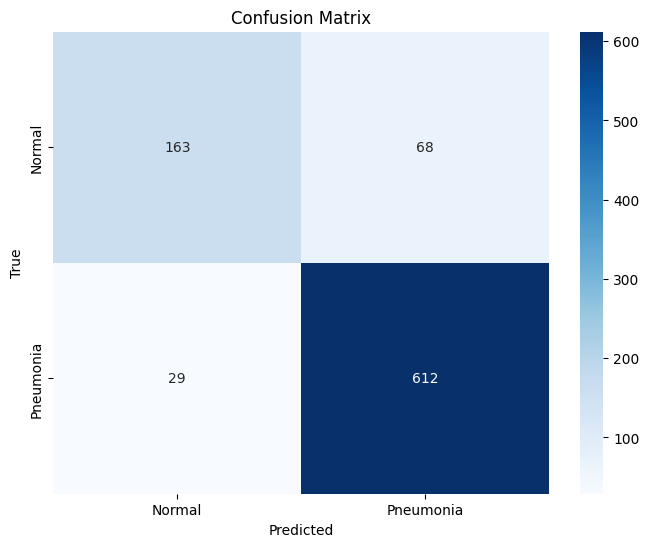

In [36]:
# plot confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
#code streanl